In [143]:
!pip install networkx[default]

In [377]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import math

In [450]:
veins = nx.Graph()
veins.add_node(0, x=0, y=0)

In [399]:
def getVeinPositionList(veins):
    x,y = [], []
    for i in veins.nodes():
        x.append(veins.nodes[i]['x'])
        y.append(veins.nodes[i]['y'])
    return x,y

In [400]:
def plot_leaf(x, y, veins, auxinSourceX, auxinSourceY):
    # Plot the complete leaf shape
    plt.figure(figsize=(6, 10))  # Make the figure taller than wide, like a leaf
    plt.plot(x, y)
    plt.title("Complete Leaf Shape")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.axis('equal')  # This ensures the aspect ratio is 1:1

    veinsX, veinsY = getVeinPositionList(veins)
    plt.plot(veinsX,veinsY, 'go')
    nx.draw_networkx_edges(veins, pos=dict(zip(veins.nodes, zip(veinsX, veinsY))))

    plt.plot(auxinSourceX, auxinSourceY, 'ro')
    plt.show()

In [401]:
def scaleGrowth(baseX, baseY, x, y, scalingFactor):
    x = baseX + scalingFactor * (x - baseX)
    y = baseY + scalingFactor * (y - baseY)
    return x, y

def growLeaf(baseX, baseY, x, y, scalingFactor, growthOfScalingFactor, deltaScalingFactor):
    scalingFactor,growthOfScalingFactor = updateScalingFactor(scalingFactor, growthOfScalingFactor, deltaScalingFactor)
    x, y = scaleGrowth(baseX, baseY, x, y, scalingFactor)
    return x,y,scalingFactor,growthOfScalingFactor

In [402]:
baseX, baseY = 0.0, 0.0

In [451]:
sourceToVeinDistanceThreshold = 0.1
sourceToSourceDistanceThreshold = 0.1
distanceVeinGrows = 0.1

In [452]:
auxinSources = []

def getAuxinSourceX(auxinSources):
    return [x for x,y in auxinSources]

def getAuxinSourceY(auxinSources):
    return [y for x,y in auxinSources]

In [453]:
# Create points for the curve
t = np.linspace(0.0001, 1, 100)  # not including 0 because 0 is leaf stem not where leaf grows.
x = np.sin(np.pi * t) * (1 - t)
y = t
# Create the mirror image by reversing the sign of x
# This combines the right side (original x values) with the left side (-x values)
x = np.concatenate([x, -x[::-1]])  # [::-1] reverses the array
y = np.concatenate([y, y[::-1]])   # Mirror the y values too to complete the loop

In [448]:
scalingFactor = 1.0
growthOfScalingFactor = 1
deltaScalingFactor = lambda f: max(f-0.1, 0)

def updateScalingFactor(scalingFactor, growthOfScalingFactor, deltaScalingFactor):
    growthOfScalingFactor = deltaScalingFactor(growthOfScalingFactor)
    scalingFactor += growthOfScalingFactor

    return scalingFactor, growthOfScalingFactor

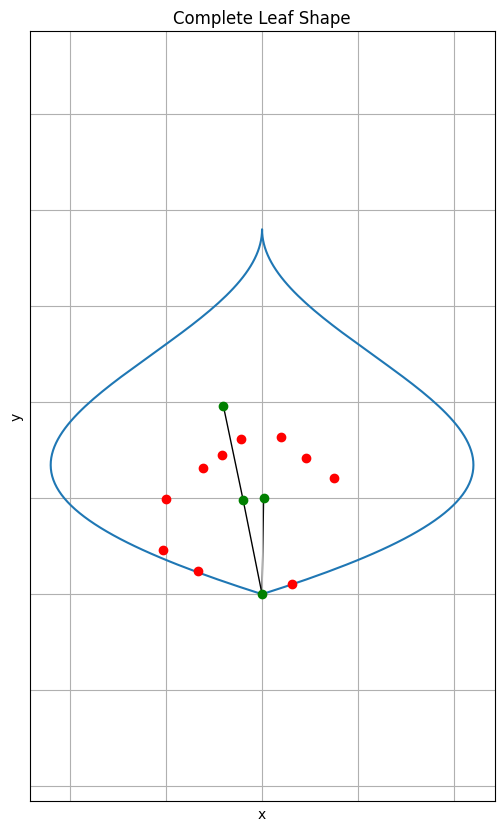

In [444]:
x, y, scalingFactor, growthOfScalingFactor = growLeaf(baseX, baseY, x, y, scalingFactor, growthOfScalingFactor, deltaScalingFactor)
plot_leaf(x, y, veins, getAuxinSourceX(auxinSources), getAuxinSourceY(auxinSources))

In [407]:
def throwDart(x, y):
    xMin, xMax = np.min(x), np.max(x)
    randomX = np.random.uniform(xMin, xMax)
    xIdx = np.argsort(np.abs(x - randomX))[:2]
    yMin, yMax = np.min(y[xIdx]), np.max(y[xIdx])
    randomY = np.random.uniform(yMin, yMax)

    return randomX, randomY

def throwDartAtEdges(x, y):
    xSorted = x[np.argsort(x)]

    xMin, xMax = xSorted[0], xSorted[-1]
    randomX = np.random.uniform(xMin, xMax)

    xIdx = np.argsort(np.abs(x - randomX))[:2]
    yMin, yMax = np.min(y[xIdx]), np.max(y[xIdx])

    return randomX, random.choice([yMin, yMax])

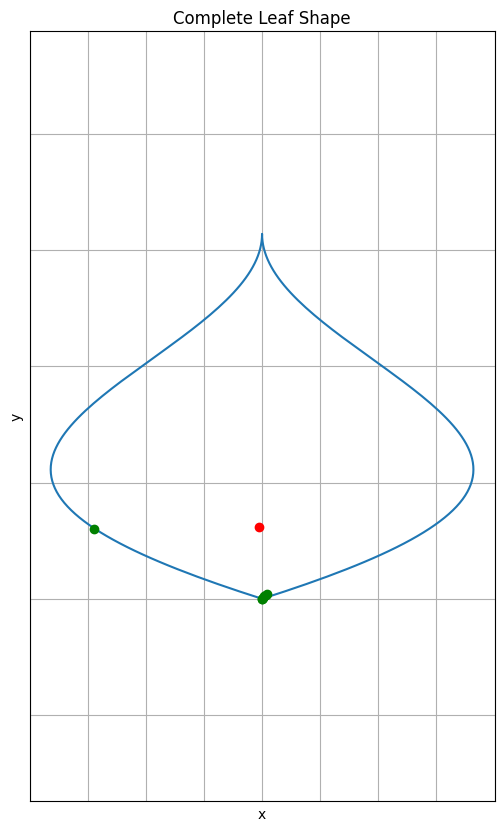

In [339]:
newVeinX, newVeinY = throwDartAtEdges(x, y)
veins.add_node(veins.number_of_nodes(), x=newVeinX, y=newVeinY)
plot_leaf(x, y, veins, getAuxinSourceX(auxinSources), getAuxinSourceY(auxinSources))

In [408]:
def distance(x1, y1, x2, y2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

In [409]:
def checkNewSourceAgainstOtherVeins(veins, newSourceX, newSourceY, thresholdBirthDistance):
    for i in veins.nodes():
        if distance(veins.nodes[i]['x'], veins.nodes[i]['y'], newSourceX, newSourceY) < thresholdBirthDistance:
            return False
    return True

def checkNewSourceAgainstOtherSources(auxinSources, newSourceX, newSourceY, thresholdDistance):
    for (x,y) in auxinSources:
        if distance(x, y, newSourceX, newSourceY) < thresholdDistance:
            return False
    return True

In [410]:
def addValidAuxinSource(veins, auxinSources, x, y, sourceToVeinDistanceThreshold, sourceToSourceDistanceThreshold):
    while True:
        newSourceX, newSourceY = throwDartAtEdges(x, y)

        if checkNewSourceAgainstOtherVeins(veins, newSourceX, newSourceY, sourceToVeinDistanceThreshold) and checkNewSourceAgainstOtherSources(auxinSources, newSourceX, newSourceY, sourceToSourceDistanceThreshold):
            # veins.add_node(veins.number_of_nodes(), x=newSourceX, y=newSourceY)
            auxinSources.append((newSourceX, newSourceY))
            break

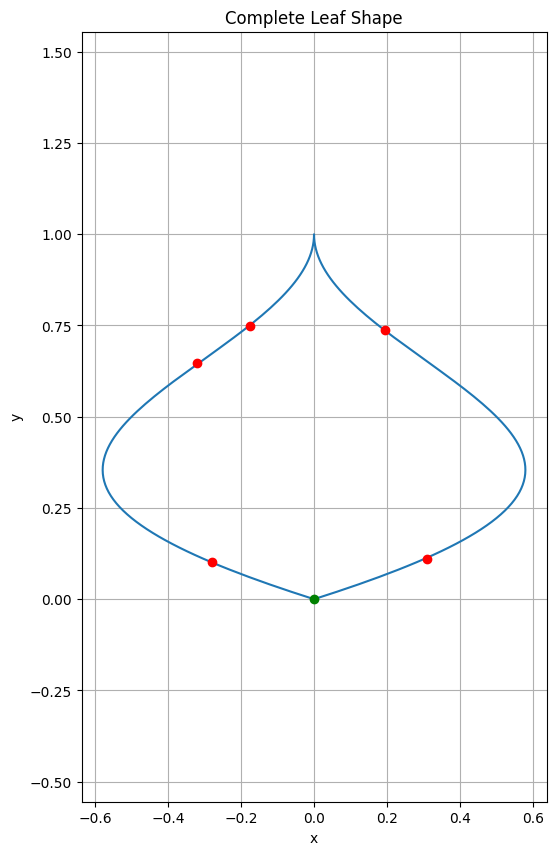

In [454]:
for i in range(5):
    addValidAuxinSource(veins, auxinSources, x, y, sourceToVeinDistanceThreshold, sourceToSourceDistanceThreshold)
plot_leaf(x, y, veins, getAuxinSourceX(auxinSources), getAuxinSourceY(auxinSources))

In [464]:
buckets = [[] for i in range(veins.number_of_nodes())]

for sourceX,sourceY in auxinSources:
    minDistance = np.inf
    minIdx = -1
    for i in veins.nodes():
        if distance(veins.nodes[i]['x'], veins.nodes[i]['y'], sourceX, sourceY) < minDistance:
            minDistance = distance(veins.nodes[i]['x'], veins.nodes[i]['y'], sourceX, sourceY)
            minIdx = i

    buckets[minIdx].append((sourceX,sourceY))

print(buckets)

[[], [(0.310601484687145, 0.1112), (-0.2782306473649925, 0.1011)], [], [], [(0.19491106727912322, 0.7373999999999999), (-0.3200517733729179, 0.6465), (-0.17540896193545996, 0.7474999999999999)]]


In [465]:
for bucketIdx, bucket in enumerate(buckets):
    if len(bucket) == 0:
        continue
    node = veins.nodes[bucketIdx]

    directionVectorX, directionVectorY = 0, 0
    for sourceX, sourceY in bucket:
        directionVectorX += (sourceX - node['x']) / distance(node['x'], node['y'], sourceX, sourceY)
        directionVectorY += (sourceY - node['y']) / distance(node['x'], node['y'], sourceX, sourceY)

    newVeinX = node['x'] + distanceVeinGrows * (directionVectorX / math.sqrt(directionVectorX**2 + directionVectorY**2))
    newVeinY = node['y'] + distanceVeinGrows * (directionVectorY / math.sqrt(directionVectorX**2 + directionVectorY**2))

    veins.add_node(veins.number_of_nodes(), x=newVeinX, y=newVeinY)
    veins.add_edge(bucketIdx, veins.number_of_nodes() - 1)

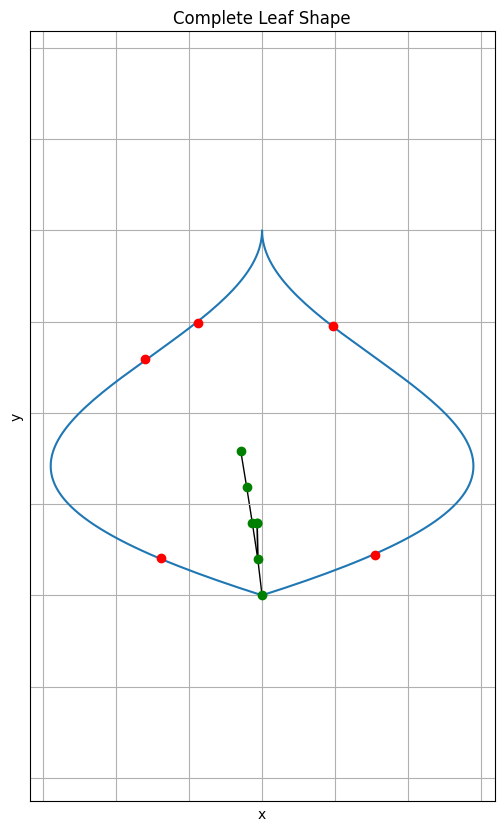

In [466]:
plot_leaf(x, y, veins, getAuxinSourceX(auxinSources), getAuxinSourceY(auxinSources))